In [ ]:
%load_ext autoreload

%autoreload 2

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

try:
    import jupyter_black
except:
    print("Jupyter-Black not found")

# Applied Machine Learning - LE3


- Pre-Processing and Pipelines
- Model Selection
- Generalization

## Imports

In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from mlxtend import plotting
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## Functions & Parameters


In [43]:
DATA_PATH = Path("../data")

HUE_ORDER=["Benign", "Malign"]
HUE_ORDER_NUM=[0, 1]


colors= sns.color_palette().as_hex()
COLORS =  [colors[0], colors[1]]

In [133]:
def plot_decision_region(X, y, clf, ax, colors, title):
    _ = plotting.plot_decision_regions(X=X, y=y.ravel(), clf=clf, ax=ax, scatter_kwargs={'s': 0}, colors=",".join(colors))
    _ = sns.scatterplot(y=X[:, 1], x=X[:, 0], hue=y.ravel(), ax=ax, hue_order=HUE_ORDER_NUM, palette=colors).set(
        title=title,
        xlabel="Fläche Tumor",
        ylim=(0, X[:, 1].max()),
        xlim=(X[:, 0].min(), X[:, 0].max()),
        ylabel="Symmetrie")
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles[2:], ['Benign', 'Malign'], framealpha=0.3, scatterpoints=1)


def undersample_malign(df, n: int = 80):
    # Undersample the Malign class
    df_malign = (
        df
        .query("diagnosis == 'Malign'")
        .sample(n=n, random_state=123)
    )

    # Get all Benign samples
    df_benign = df.query("diagnosis == 'Benign'")

    # Combine to create a balanced dataset
    return pd.concat([df_benign, df_malign])

## Data

In [140]:
df_raw = pd.read_csv(DATA_PATH.joinpath("breast-cancer.csv")).drop('Unnamed: 32', axis=1)

df_breast_cancer = (
    df_raw
    .assign(diagnosis=lambda _df: _df['diagnosis'].map({'M': "Malign", 'B': "Benign"}))
    .astype({"diagnosis": "category"})
)

In [141]:
df_breast_cancer = undersample_malign(df_breast_cancer, 100)

In [142]:
df_breast_cancer[["diagnosis", "symmetry_worst", "area_mean"]].head()

,diagnosis,symmetry_worst,area_mean
19,Benign,0.2977,566.3
20,Benign,0.3184,520.0
21,Benign,0.2450,273.9
37,Benign,0.1987,523.8
46,Benign,0.3105,201.9


In [143]:
df_breast_cancer.groupby("diagnosis", observed=True).size()

diagnosis
Benign    357
Malign    100
dtype: int64

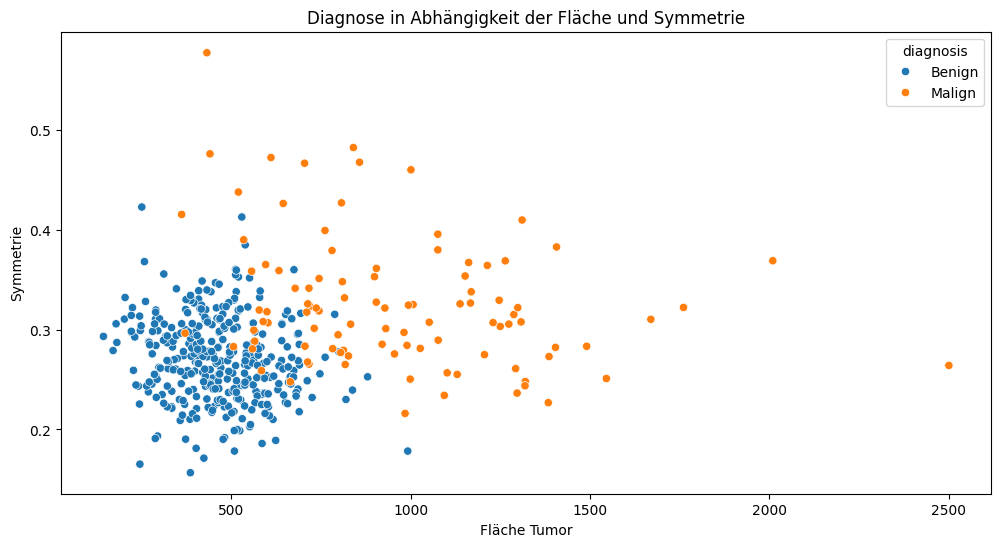

In [144]:
fig, ax = plt.subplots(figsize=(12, 6))
_ = sns.scatterplot(data=df_breast_cancer, y="symmetry_worst", x='area_mean', hue='diagnosis', ax=ax, hue_order=HUE_ORDER, palette=COLORS).set(
    title="Diagnose in Abhängigkeit der Fläche und Symmetrie",
    xlabel="Fläche Tumor",
    ylabel="Symmetrie")

Prepare Data for modelling.

In [145]:
from sklearn.preprocessing import LabelEncoder

# Create data matrix X and label vector y
X2d = df_breast_cancer[['area_mean', 'symmetry_worst']].to_numpy()
X = df_breast_cancer.drop(["id", "diagnosis"], axis=1).to_numpy()
y = df_breast_cancer[['diagnosis']].to_numpy().reshape(-1,)

label_encoder = LabelEncoder().fit(y)
y = label_encoder.transform(y)

print(label_encoder.classes_)


['Benign' 'Malign']


## Ein erstes Modell

In [146]:
# train a logistic regression model
clf = LogisticRegression()
clf = clf.fit(X2d, y)

# train a random forest classifier
clf2 = RandomForestClassifier(n_estimators=50)
clf2 = clf2.fit(X=X2d, y=y)

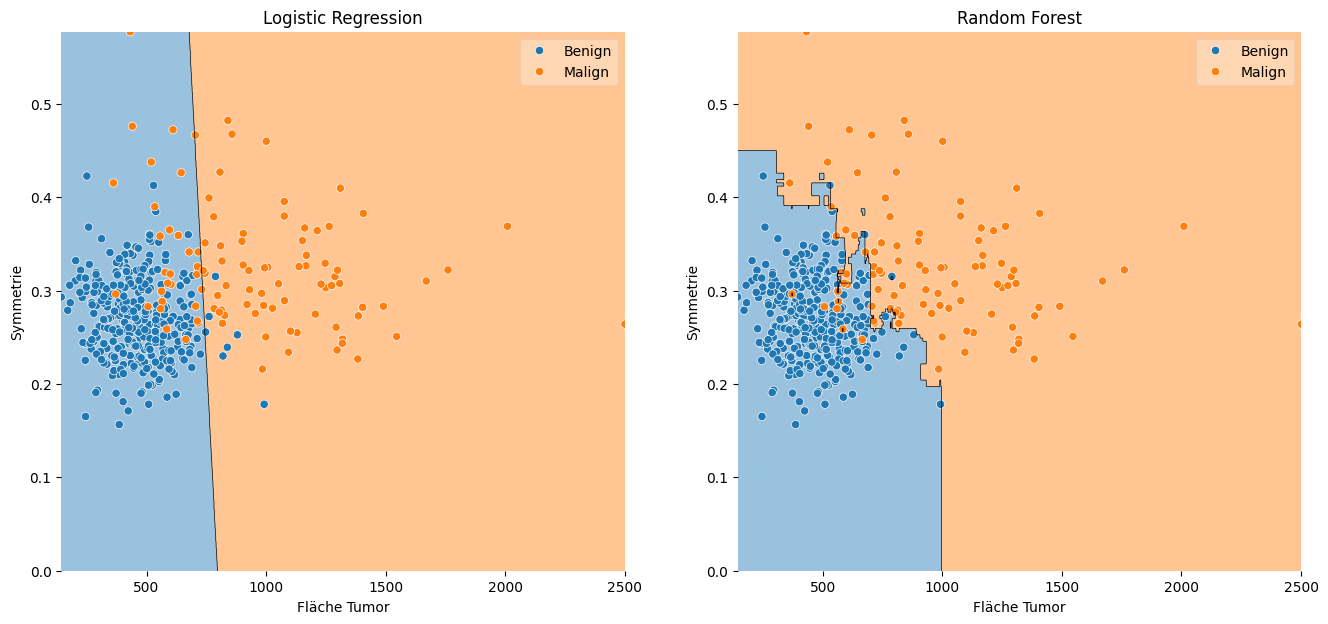

In [147]:
fig, axes = plt.subplots(figsize=(16, 7), ncols=2)
plot_decision_region(X2d, y, clf, axes[0], COLORS, title="Logistic Regression")
plot_decision_region(X2d, y, clf2, axes[1], COLORS, title="Random Forest")

Accuracy:

In [148]:
print(f"Accuracy Logistic Regression: {clf.score(X2d, y):.2f}")
print(f"Accuracy Random Forest: {clf2.score(X2d, y):.2f}")

Accuracy Logistic Regression: 0.92
Accuracy Random Forest: 1.00


**Offensichtlich: Random Forest is the Winner!**

## Modell Selektion

Wir brauchen ein Validation und Test Set!

![Train Test Split](../figures/train_test.jpg)

In [149]:
from sklearn.model_selection import train_test_split


X2d_train, X2d_test, y_train, y_test = train_test_split(X2d, y, test_size=0.2, random_state=123, stratify=y)
X2d_train, X2d_val, y_train, y_val = train_test_split(X2d_train, y_train, test_size=0.2, random_state=123, stratify=y_train)


clf = LogisticRegression()
clf = clf.fit(X2d_train, y_train)

# train a random forest classifier
clf2 = RandomForestClassifier(n_estimators=50)
clf2 = clf2.fit(X=X2d_train, y=y_train)


print(f"Accuracy Logistic Regression: {clf.score(X2d_val, y_val):.2f}")
print(f"Accuracy Random Forest: {clf2.score(X2d_val, y_val):.2f}")

Accuracy Logistic Regression: 0.92
Accuracy Random Forest: 0.90


Nun können wir das beste Modell auf dem Testset evaluieren.

In [150]:
print(f"Accuracy Random Forest: {clf2.score(X2d_test, y_test):.2f}")

Accuracy Random Forest: 0.90


Wie robust ist dieses Resultat?

In [151]:
deltas = list()
for random_state in range(0, 100):

    X2d_train, X2d_test, y_train, y_test = train_test_split(X2d, y, test_size=0.2, random_state=123, stratify=y)
    X2d_train, X2d_val, y_train, y_val = train_test_split(X2d_train, y_train, test_size=0.2, random_state=random_state, stratify=y_train)

    clf = LogisticRegression()
    clf = clf.fit(X2d_train, y_train)

    # train a random forest classifier
    clf2 = RandomForestClassifier(n_estimators=50)
    clf2 = clf2.fit(X=X2d_train, y=y_train)

    deltas.append(clf.score(X2d_val, y_val) - clf2.score(X2d_val, y_val))


np.int64(12)

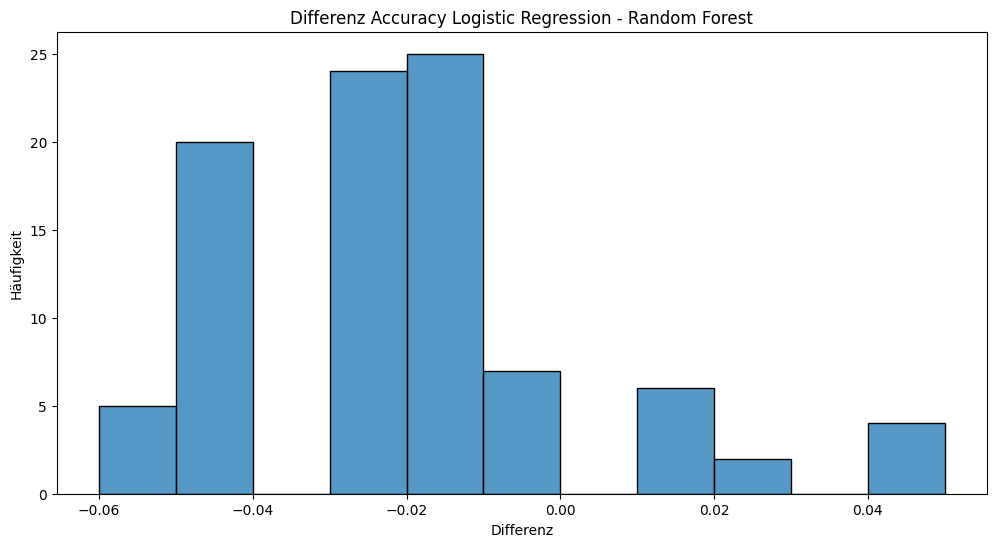

In [152]:
fig, ax = plt.subplots(figsize=(12, 6))
_ = sns.histplot(deltas, bins=np.arange(-0.06, 0.06, 0.01), ax=ax).set(title="Differenz Accuracy Logistic Regression - Random Forest", xlabel="Differenz", ylabel="Häufigkeit")

sum(np.array(deltas) > 0)

## Kreuzvalidierung

![Kreuzvalidierung](../figures/xval.jpg)

Quelle: _Sebastian Raschka and Vahid Mirjalili. Python Machine Learning, 3rd Ed. Packt Publishing, Birmingham, UK, 3 edition, 2019. ISBN 978-1-78995-575-0._

Ein Beispiel.

In [153]:
from sklearn.model_selection import KFold

X2d_train, X2d_test, y_train, y_test = train_test_split(X2d, y, test_size=0.2, random_state=123, stratify=y)

cv = KFold(n_splits=5, shuffle=True, random_state=123)

results  = list()

for train_idx, validation_idx in cv.split(X2d_train, y_train):

    X_train_split, y_train_split = X2d_train[train_idx], y_train[train_idx]
    X_val_split, y_val_split = X2d_train[validation_idx], y_train[validation_idx]

    clf = LogisticRegression()
    clf = clf.fit(X_train_split, y_train_split)

    # train a random forest classifier
    clf2 = RandomForestClassifier(n_estimators=50, random_state=123)
    clf2 = clf2.fit(X=X_train_split, y=y_train_split)

    results.append({"model": "Logistic Regression", "accuracy": clf.score(X_val_split, y_val_split)})
    results.append({"model": "Random Forest", "accuracy": clf2.score(X_val_split, y_val_split)})
    

In [154]:
df_results = pd.DataFrame.from_records(results)
df_results.groupby("model").agg({"accuracy": ["mean", "std"]})

accuracy          
                         mean       std
model                                  
Logistic Regression  0.917808  0.016777
Random Forest        0.953425  0.007503

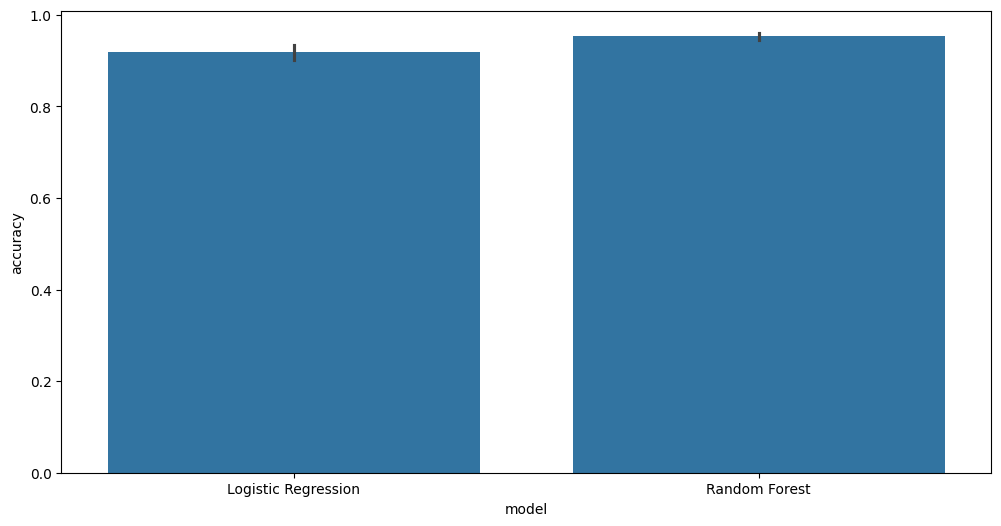

In [155]:
fig, ax = plt.subplots(figsize=(12, 6))
_ = sns.barplot(df_results, x="model", y="accuracy", errorbar="sd", ax=ax)

**Was passiert wenn man mehr oder weniger folds wählt?**

## Hyper-Parameter Optimierung


Die meisten Algorithmen haben Hyper-Parameter welche den Optimisierungsprozess beeinflussen. Diese können wir nicht direkt mit dem Trainingsset optimieren, sondern müssen ein Validation Set verwenden.

In [156]:
X2d_train, X2d_test, y_train, y_test = train_test_split(X2d, y, test_size=0.2, random_state=123, stratify=y)

cv = KFold(n_splits=5, shuffle=True, random_state=123)

results  = list()

for train_idx, validation_idx in cv.split(X2d_train, y_train):

    X_train_split, y_train_split = X2d_train[train_idx], y_train[train_idx]
    X_val_split, y_val_split = X2d_train[validation_idx], y_train[validation_idx]

    clf = LogisticRegression()
    clf = clf.fit(X_train_split, y_train_split)

    # train a random forest classifier
    clf2 = RandomForestClassifier(n_estimators=50, random_state=123)
    clf2 = clf2.fit(X=X_train_split, y=y_train_split)

    clf3 = RandomForestClassifier(n_estimators=150)
    clf3 = clf3.fit(X=X_train_split, y=y_train_split)

    results.append({"model": "Logistic Regression", "accuracy": clf.score(X_val_split, y_val_split)})
    results.append({"model": "Random Forest", "accuracy": clf2.score(X_val_split, y_val_split)})
    results.append({"model": "Random Forest2", "accuracy": clf3.score(X_val_split, y_val_split)})

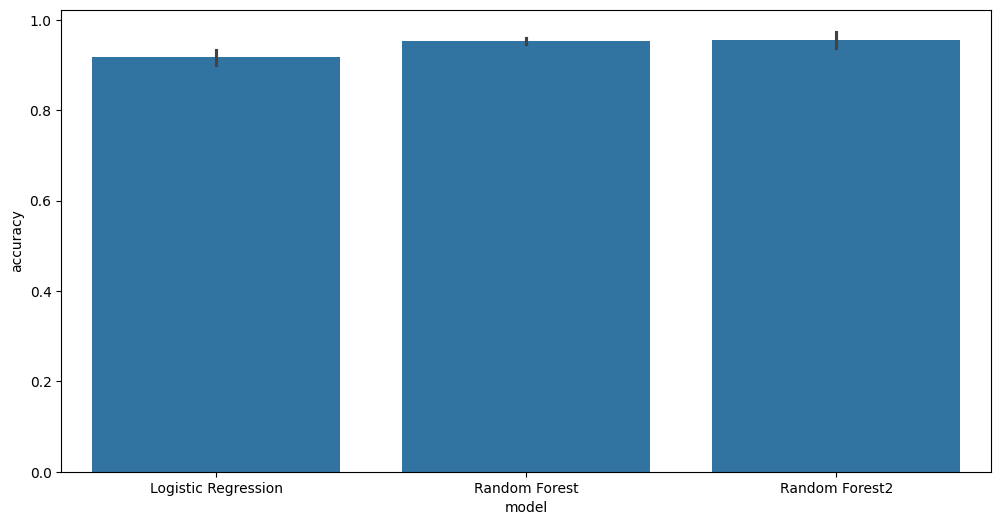

In [157]:
df_results = pd.DataFrame.from_records(results)

fig, ax = plt.subplots(figsize=(12, 6))
_ = sns.barplot(df_results, x="model", y="accuracy", errorbar="sd", ax=ax)

### Grid-Search

Man kann verschiedene Hyper-Parameter Kombinationen einfach mit [sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) ausprobieren.

In [158]:
from sklearn.model_selection import GridSearchCV

cv = KFold(n_splits=5, shuffle=True, random_state=123)

algorithms = {
    "random_forest": {
        "cls": RandomForestClassifier,
        "hyper_params": {
            "n_estimators": [50, 100, 200],
            "random_state": [123],
            "max_depth": [1, 3, 5, 10, 15]
        }
    },
    "logistic_regression": {
        "cls": LogisticRegression,
        "hyper_params": {
            "C": [0.1,  0.0001],
            "random_state": [123],
        }
    }
}

for algorithm_name, algorithm_data in algorithms.items():

    param_grid = algorithm_data["hyper_params"]
    algorithm = algorithm_data["cls"]
    grid_search = GridSearchCV(
            algorithm(),
            param_grid=param_grid,
            cv=cv,
            n_jobs=-1,
        )
    
    grid_search.fit(X2d_train, y_train)

# Best parameters and estimator
print("Best parameters:", grid_search.best_params_)
print("Best estimator:", grid_search.best_estimator_)
print(f"Best score: {grid_search.best_score_:.2f}")

GridSearchCV(cv=KFold(n_splits=5, random_state=123, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 5, 10, 15],
                         'n_estimators': [50, 100, 200],
                         'random_state': [123]})

GridSearchCV(cv=KFold(n_splits=5, random_state=123, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.1, 0.0001], 'random_state': [123]})

Best parameters: {'C': 0.1, 'random_state': 123}
Best estimator: LogisticRegression(C=0.1, random_state=123)
Best score: 0.92


**Vielleicht sollte ich die Daten skalieren?**

## Pipelines

![Pipelines](../figures/ml_pipelines.jpg)

Quelle: _Sebastian Raschka and Vahid Mirjalili. Python Machine Learning, 3rd Ed. Packt Publishing, Birmingham, UK, 3 edition, 2019. ISBN 978-1-78995-575-0._

In [159]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

cv = KFold(n_splits=5, shuffle=True, random_state=123)



algorithms = {
    "random_forest": {
        "cls": RandomForestClassifier(random_state=123),
        "hyper_params": {
            "cls__n_estimators": [50, 100, 200],
            "cls__max_depth": [1, 3, 5, 10, 15],
        }
    },
    "logistic_regression": {
        "cls": LogisticRegression(random_state=123),
        "hyper_params": {
            "cls__C": [0.1,  0.0001],
        }
    }
}

for algorithm_name, algorithm_data in algorithms.items():

    param_grid = algorithm_data["hyper_params"]
    algorithm = algorithm_data["cls"]

    pipeline = Pipeline([("scaler", StandardScaler()), ("cls", algorithm)])
    
    grid_search = GridSearchCV(
            pipeline,
            param_grid=param_grid,
            cv=cv,
            n_jobs=-1,
        )
    
    grid_search.fit(X2d_train, y_train)

# Best parameters and estimator
print("Best parameters:", grid_search.best_params_)
print("Best estimator:", grid_search.best_estimator_)
print(f"Best score: {grid_search.best_score_:.2f}")

GridSearchCV(cv=KFold(n_splits=5, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('cls',
                                        RandomForestClassifier(random_state=123))]),
             n_jobs=-1,
             param_grid={'cls__max_depth': [1, 3, 5, 10, 15],
                         'cls__n_estimators': [50, 100, 200]})

GridSearchCV(cv=KFold(n_splits=5, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('cls',
                                        LogisticRegression(random_state=123))]),
             n_jobs=-1, param_grid={'cls__C': [0.1, 0.0001]})

Best parameters: {'cls__C': 0.1}
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('cls', LogisticRegression(C=0.1, random_state=123))])
Best score: 0.92


**Was wenn ich verschiedene Pre-Processing Schritte ausprobieren möchte?**

In [160]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

cv = KFold(n_splits=5, shuffle=True, random_state=123)


# Combined pipeline with conditional preprocessing
pipeline = Pipeline([
    ('pre_processing', 'passthrough'),  # placeholder
    ('cls', LogisticRegression())       # placeholder
])

param_grid = [
    # Random Forest (no scaling)
    {
        "pre_processing": ["passthrough"],
        "cls": [RandomForestClassifier(random_state=123)],
        "cls__n_estimators": [50, 100, 200],
        "cls__max_depth": [1, 3, 5, 10, 15],
    },
    # Logistic Regression (with scaling)
    {
        "pre_processing": [StandardScaler(), MinMaxScaler()],
        "cls": [LogisticRegression(random_state=123)],
        "cls__C": [0.1, 0.0001],
    }
]

# GridSearch with conditional preprocessing
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1,
)
    
grid_search.fit(X2d_train, y_train)

# Best parameters and estimator
print("Best parameters:", grid_search.best_params_)
print("Best estimator:", grid_search.best_estimator_)
print(f"Best score: {grid_search.best_score_:.2f}")

GridSearchCV(cv=KFold(n_splits=5, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('pre_processing', 'passthrough'),
                                       ('cls', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'cls': [RandomForestClassifier(random_state=123)],
                          'cls__max_depth': [1, 3, 5, 10, 15],
                          'cls__n_estimators': [50, 100, 200],
                          'pre_processing': ['passthrough']},
                         {'cls': [LogisticRegression(random_state=123)],
                          'cls__C': [0.1, 0.0001],
                          'pre_processing': [StandardScaler(),
                                             MinMaxScaler()]}])

Best parameters: {'cls': RandomForestClassifier(random_state=123), 'cls__max_depth': 10, 'cls__n_estimators': 100, 'pre_processing': 'passthrough'}
Best estimator: Pipeline(steps=[('pre_processing', 'passthrough'),
                ('cls',
                 RandomForestClassifier(max_depth=10, random_state=123))])
Best score: 0.96


In [161]:
df_results = pd.DataFrame.from_records(grid_search.cv_results_)
df_results.sort_values("rank_test_score").head(5)[["mean_test_score", "param_cls", "param_cls__C", "param_cls__n_estimators", "param_cls__max_depth", "param_pre_processing"]]

,mean_test_score,param_cls,param_cls__C,param_cls__n_estimators,param_cls__max_depth,param_pre_processing
13,0.958904,RandomForestClassifier(random_state=123),NaN,100.0,15.0,passthrough
14,0.958904,RandomForestClassifier(random_state=123),NaN,200.0,15.0,passthrough
10,0.958904,RandomForestClassifier(random_state=123),NaN,100.0,10.0,passthrough
11,0.958904,RandomForestClassifier(random_state=123),NaN,200.0,10.0,passthrough
6,0.956164,RandomForestClassifier(random_state=123),NaN,50.0,5.0,passthrough


## Metriken

Wie messe ich die Güte / Performance von einem Modell?

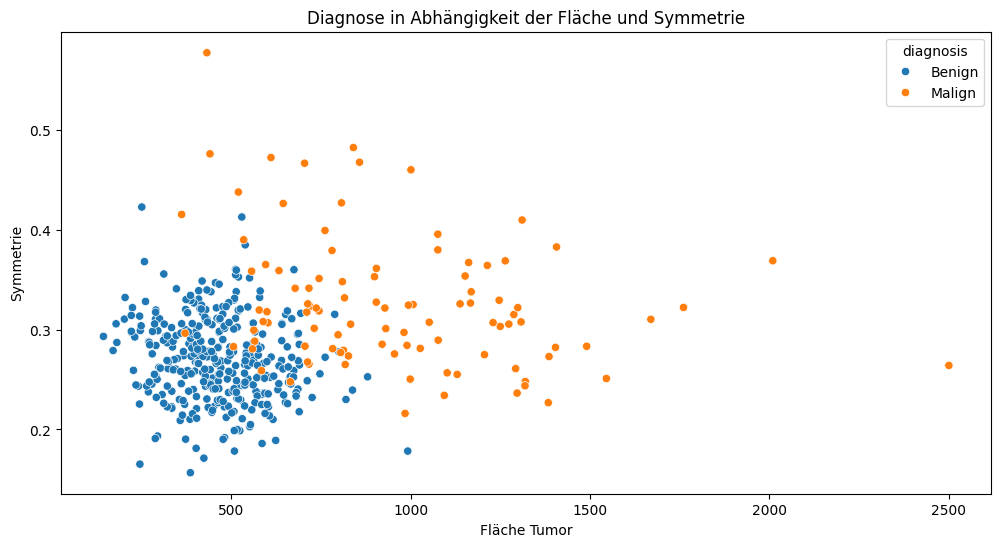

In [162]:
fig, ax = plt.subplots(figsize=(12, 6))
_ = sns.scatterplot(data=df_breast_cancer, y="symmetry_worst", x='area_mean', hue='diagnosis', ax=ax, hue_order=HUE_ORDER, palette=COLORS).set(
    title="Diagnose in Abhängigkeit der Fläche und Symmetrie",
    xlabel="Fläche Tumor",
    ylabel="Symmetrie")

Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix (Cross-validated predictions)')

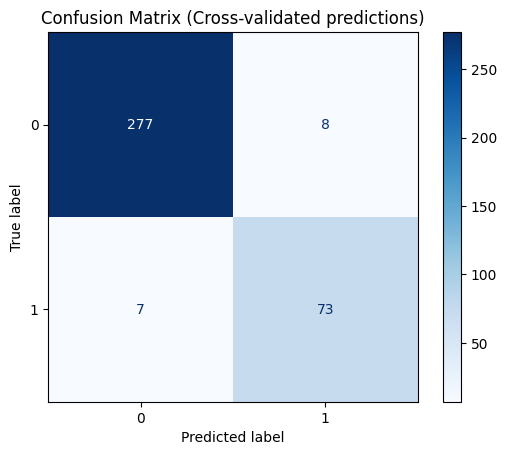

In [163]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict

# Obtain the best estimator pipeline from GridSearchCV
best_pipeline = grid_search.best_estimator_

# Use cross_val_predict to get validation predictions across folds
y_pred_cv = cross_val_predict(best_pipeline, X2d_train, y_train, cv=cv, n_jobs=-1)

# Compute confusion matrix
cm = confusion_matrix(y_train, y_pred_cv)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (Cross-validated predictions)')
plt.show()


Fast 10% der positiven Fälle werden nicht erkannt.

In [166]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)

# Combined pipeline with conditional preprocessing
pipeline = Pipeline([
    ('pre_processing', 'passthrough'),  # placeholder
    ('cls', LogisticRegression())       # placeholder
])

# Updated param grid to conditionally apply scaling
param_grid = [
    # Random Forest (no scaling)
    {
        "pre_processing": ["passthrough"],
        "cls": [RandomForestClassifier(random_state=123)],
        "cls__n_estimators": [50, 100, 200],
        "cls__max_depth": [1, 3, 5, 10, 15],
    },
    # Logistic Regression (with scaling)
    {
        "pre_processing": [StandardScaler(), MinMaxScaler()],
        "cls": [LogisticRegression(random_state=123)],
        "cls__C": [0.1, 0.0001],
    }
]

# GridSearch with conditional preprocessing
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
)

grid_search.fit(X2d_train, y_train)

# Best parameters and estimator
print("Best parameters:", grid_search.best_params_)
print("Best estimator:", grid_search.best_estimator_)
print(f"Best score: {grid_search.best_score_:.2f}")

GridSearchCV(cv=KFold(n_splits=5, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('pre_processing', 'passthrough'),
                                       ('cls', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'cls': [RandomForestClassifier(random_state=123)],
                          'cls__max_depth': [1, 3, 5, 10, 15],
                          'cls__n_estimators': [50, 100, 200],
                          'pre_processing': ['passthrough']},
                         {'cls': [LogisticRegression(random_state=123)],
                          'cls__C': [0.1, 0.0001],
                          'pre_processing': [StandardScaler(),
                                             MinMaxScaler()]}],
             scoring='roc_auc')

Best parameters: {'cls': RandomForestClassifier(random_state=123), 'cls__max_depth': 5, 'cls__n_estimators': 100, 'pre_processing': 'passthrough'}
Best estimator: Pipeline(steps=[('pre_processing', 'passthrough'),
                ('cls', RandomForestClassifier(max_depth=5, random_state=123))])
Best score: 0.99


Text(0.5, 1.0, 'Confusion Matrix (Cross-validated predictions)')

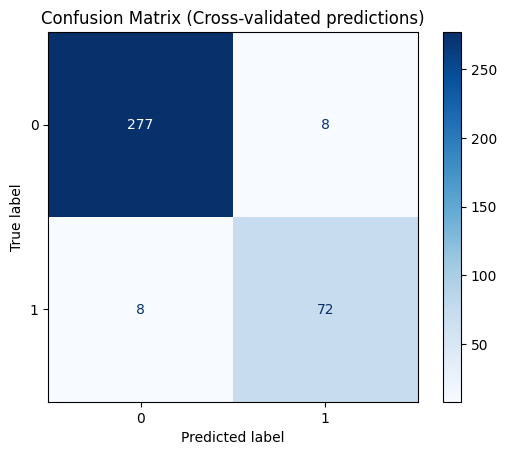

In [167]:
best_pipeline = grid_search.best_estimator_

# Use cross_val_predict to get validation predictions across folds
y_pred_cv = cross_val_predict(best_pipeline, X2d_train, y_train, cv=cv, n_jobs=-1)

# Compute confusion matrix
cm = confusion_matrix(y_train, y_pred_cv)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (Cross-validated predictions)')
plt.show()


More complex cost functions

In [168]:
from sklearn.metrics import make_scorer, confusion_matrix

def cost_metric(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Define your costs here (example values):
    cost_fp = 5  # Cost of false positive
    cost_fn = 50  # Cost of false negative
    cost_tp = 0   # Benefit (negative cost) of true positive
    cost_tn = 0   # Cost of true negative (typically zero)
    
    # Compute total cost
    total_cost = (fp * cost_fp) + (fn * cost_fn) + (tp * cost_tp) + (tn * cost_tn)
    return total_cost

# Create scorer (lower is better, hence greater_is_better=False)
cost_scorer = make_scorer(cost_metric, greater_is_better=False)

In [174]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)

# Combined pipeline with conditional preprocessing
pipeline = Pipeline([
    ('pre_processing', 'passthrough'),  # placeholder
    ('cls', LogisticRegression())       # placeholder
])

# Updated param grid to conditionally apply scaling
param_grid = [
    # Random Forest (no scaling)
    {
        "pre_processing": ["passthrough"],
        "cls": [RandomForestClassifier(random_state=123)],
        "cls__n_estimators": [50, 100, 200],
        "cls__max_depth": [1, 3, 5, 10, 15],
    },
    # Logistic Regression (with scaling)
    {
        "pre_processing": [StandardScaler(), MinMaxScaler()],
        "cls": [LogisticRegression(random_state=123)],
        "cls__C": [0.1, 0.0001],
    }
]

# GridSearch with conditional preprocessing
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring=cost_scorer,
    n_jobs=-1,
)

grid_search.fit(X2d_train, y_train)

# Best parameters and estimator
print("Best parameters:", grid_search.best_params_)
print("Best estimator:", grid_search.best_estimator_)
print(f"Best score: {grid_search.best_score_:.2f}")

GridSearchCV(cv=KFold(n_splits=5, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('pre_processing', 'passthrough'),
                                       ('cls', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'cls': [RandomForestClassifier(random_state=123)],
                          'cls__max_depth': [1, 3, 5, 10, 15],
                          'cls__n_estimators': [50, 100, 200],
                          'pre_processing': ['passthrough']},
                         {'cls': [LogisticRegression(random_state=123)],
                          'cls__C': [0.1, 0.0001],
                          'pre_processing': [StandardScaler(),
                                             MinMaxScaler()]}],
             scoring=make_scorer(cost_metric, greater_is_better=False, response_method='predict'))

Best parameters: {'cls': RandomForestClassifier(random_state=123), 'cls__max_depth': 10, 'cls__n_estimators': 100, 'pre_processing': 'passthrough'}
Best estimator: Pipeline(steps=[('pre_processing', 'passthrough'),
                ('cls',
                 RandomForestClassifier(max_depth=10, random_state=123))])
Best score: -78.00


Text(0.5, 1.0, 'Confusion Matrix (Cross-validated predictions)')

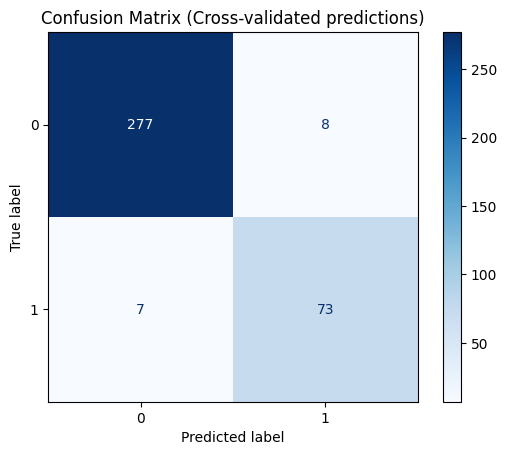

In [176]:
best_pipeline = grid_search.best_estimator_

# Use cross_val_predict to get validation predictions across folds
y_pred_cv = cross_val_predict(best_pipeline, X2d_train, y_train, cv=cv, n_jobs=-1)

# Compute confusion matrix
cm = confusion_matrix(y_train, y_pred_cv)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (Cross-validated predictions)')
plt.show()

### Tuning the Threshold

In [177]:
from sklearn.model_selection import TunedThresholdClassifierCV

In [178]:
tuned_model = TunedThresholdClassifierCV(
    estimator=grid_search.best_estimator_,
    cv=cv,
    scoring=cost_scorer,
    store_cv_results=True,  # necessary to inspect all results
)

tuned_model.fit(X2d_train, y_train)
print(f"{tuned_model.best_threshold_=:0.2f}")

TunedThresholdClassifierCV(cv=KFold(n_splits=5, random_state=123, shuffle=True),
                           estimator=Pipeline(steps=[('pre_processing',
                                                      'passthrough'),
                                                     ('cls',
                                                      RandomForestClassifier(max_depth=10,
                                                                             random_state=123))]),
                           scoring=make_scorer(cost_metric, greater_is_better=False, response_method='predict'),
                           store_cv_results=True)

tuned_model.best_threshold_=0.09


Text(0.5, 1.0, 'Confusion Matrix (Cross-validated predictions)')

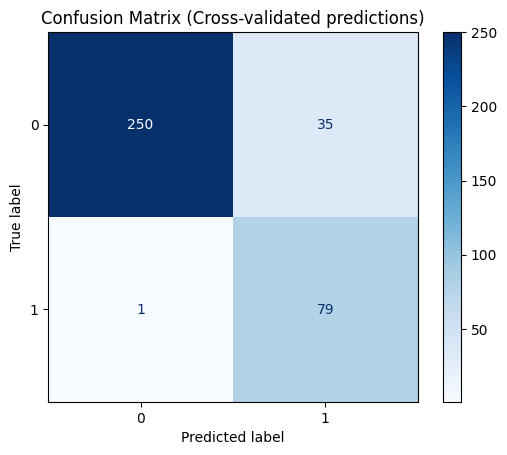

In [181]:

# Use cross_val_predict to get validation predictions across folds
y_pred_cv = cross_val_predict(tuned_model, X2d_train, y_train, cv=cv, n_jobs=-1)

# Compute confusion matrix
cm = confusion_matrix(y_train, y_pred_cv)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (Cross-validated predictions)')
plt.show()

Achtung positiver Bias!

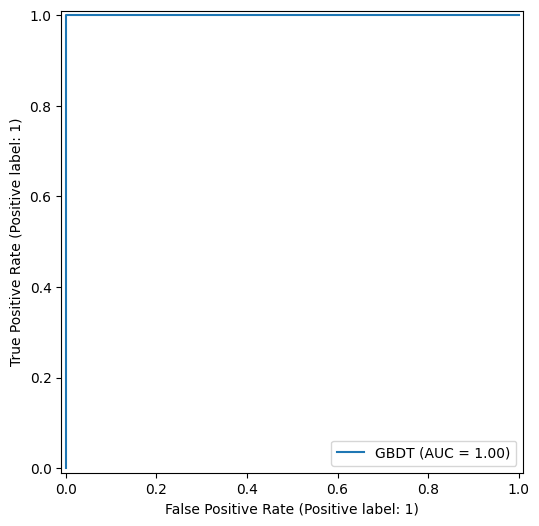

In [180]:

from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay


fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))

RocCurveDisplay.from_estimator(
    grid_search.best_estimator_, X2d_train, y_train, pos_label=1, ax=axs, name="GBDT"
)


## Oversampling

In [183]:
from imblearn.over_sampling import SMOTE, ADASYN

X2d_resampled_train, y_resampled_train = SMOTE().fit_resample(X2d_train, y_train)

print(f"Sampled: {X2d_resampled_train.shape[0] - X2d_train.shape[0]}")

np.bincount(y_resampled_train)

Sampled: 205


array([285, 285])

In [184]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)

# Combined pipeline with conditional preprocessing
pipeline = Pipeline([
    ('pre_processing', 'passthrough'),  # placeholder
    ('cls', LogisticRegression())       # placeholder
])

# Updated param grid to conditionally apply scaling
param_grid = [
    # Random Forest (no scaling)
    {
        "pre_processing": ["passthrough"],
        "cls": [RandomForestClassifier(random_state=123)],
        "cls__n_estimators": [50, 100, 200],
        "cls__max_depth": [1, 3, 5, 10, 15],
    },
    # Logistic Regression (with scaling)
    {
        "pre_processing": [StandardScaler(), MinMaxScaler()],
        "cls": [LogisticRegression(random_state=123)],
        "cls__C": [0.1, 0.0001],
    }
]

# GridSearch with conditional preprocessing
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring=cost_scorer,
    n_jobs=-1,
)

grid_search.fit(X2d_resampled_train, y_resampled_train)

# Best parameters and estimator
print("Best parameters:", grid_search.best_params_)
print("Best estimator:", grid_search.best_estimator_)
print(f"Best score: {grid_search.best_score_:.2f}")

GridSearchCV(cv=KFold(n_splits=5, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('pre_processing', 'passthrough'),
                                       ('cls', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'cls': [RandomForestClassifier(random_state=123)],
                          'cls__max_depth': [1, 3, 5, 10, 15],
                          'cls__n_estimators': [50, 100, 200],
                          'pre_processing': ['passthrough']},
                         {'cls': [LogisticRegression(random_state=123)],
                          'cls__C': [0.1, 0.0001],
                          'pre_processing': [StandardScaler(),
                                             MinMaxScaler()]}],
             scoring=make_scorer(cost_metric, greater_is_better=False, response_method='predict'))

Best parameters: {'cls': RandomForestClassifier(random_state=123), 'cls__max_depth': 5, 'cls__n_estimators': 50, 'pre_processing': 'passthrough'}
Best estimator: Pipeline(steps=[('pre_processing', 'passthrough'),
                ('cls',
                 RandomForestClassifier(max_depth=5, n_estimators=50,
                                        random_state=123))])
Best score: -74.00


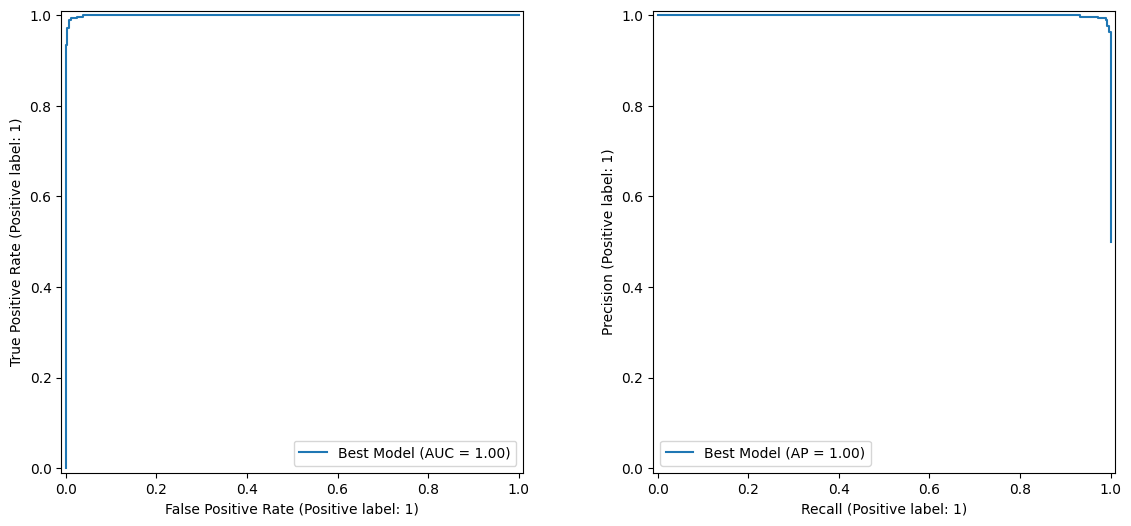

In [185]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

_ = RocCurveDisplay.from_estimator(
    grid_search.best_estimator_, X2d_resampled_train, y_resampled_train, pos_label=1, ax=axs[0], name="Best Model",
)

_ = PrecisionRecallDisplay.from_estimator(
    grid_search.best_estimator_, X2d_resampled_train, y_resampled_train, pos_label=1, ax=axs[1], name="Best Model",
)


Alles gut?

In [186]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


cv = KFold(n_splits=5, shuffle=True, random_state=123)

# Combined pipeline with conditional preprocessing
pipeline = ImbPipeline([
    ('pre_processing', 'passthrough'),  
    ('sampling', 'passthrough'),        
    ('cls', LogisticRegression())       # placeholder
])

# Updated param grid to conditionally apply scaling
param_grid = [
    # Random Forest (no scaling)
    {
        "pre_processing": ["passthrough"],
        "cls": [RandomForestClassifier(random_state=123)],
        "cls__n_estimators": [50, 100, 200],
        "cls__max_depth": [1, 3, 5, 10, 15],
        "sampling": ["passthrough"],
    },
    {
        "pre_processing": ["passthrough"],
        "cls": [RandomForestClassifier(random_state=123)],
        "cls__n_estimators": [50, 100, 200],
        "cls__max_depth": [1, 3, 5, 10, 15],
        "sampling": [SMOTE()],
        'sampling__k_neighbors': [3, 5, 7],
    },
    # Logistic Regression (with scaling)
    {
        "pre_processing": [StandardScaler()],
        "cls": [LogisticRegression(random_state=123)],
        "cls__class_weight": ["balanced", None, {1: 10, 0: 1}],
        "cls__C": [0.1, 0.0001],
        "sampling": ["passthrough"],
    },
    # Logistic Regression (with scaling)
    {
        "pre_processing": [StandardScaler()],
        "cls": [LogisticRegression(random_state=123)],
        "cls__class_weight": ["balanced", None, {1: 10, 0: 1}],
        "cls__C": [0.1, 0.0001],
        "sampling": [SMOTE()],
        'sampling__k_neighbors': [3, 5, 7],
    }
]

# GridSearch with conditional preprocessing
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
)


grid_search.fit(X2d_train, y=y_train)

# Best parameters and estimator
print("Best parameters:", grid_search.best_params_)
print("Best estimator:", grid_search.best_estimator_)
print(f"Best score: {grid_search.best_score_:.2f}")

GridSearchCV(cv=KFold(n_splits=5, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('pre_processing', 'passthrough'),
                                       ('sampling', 'passthrough'),
                                       ('cls', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'cls': [RandomForestClassifier(random_state=123)],
                          'cls__max_depth': [1, 3, 5, 10, 15],
                          'cls__n_estimators': [50, 100, 200],
                          'pre_processing': ['passthrough'],...
                          'cls__C': [0.1, 0.0001],
                          'cls__class_weight': ['balanced', None,
                                                {0: 1, 1: 10}],
                          'pre_processing': [StandardScaler()],
                          'sampling': ['passthrough']},
                         {'cls': [LogisticRegression(random_state=123)],
                          'cls__C': [0.1, 0.0001],
                          'cls__class_weight': ['balanced', None,
                                                {0: 1, 1: 10}],
                          'pre_processing': [StandardScaler()],
                          'sampling': [SMOTE()],
                          'sampling__k_neighbors': [3, 5, 7]}],
             scoring='roc_auc')

Best parameters: {'cls': RandomForestClassifier(random_state=123), 'cls__max_depth': 10, 'cls__n_estimators': 200, 'pre_processing': 'passthrough', 'sampling': SMOTE(), 'sampling__k_neighbors': 3}
Best estimator: Pipeline(steps=[('pre_processing', 'passthrough'),
                ('sampling', SMOTE(k_neighbors=3)),
                ('cls',
                 RandomForestClassifier(max_depth=10, n_estimators=200,
                                        random_state=123))])
Best score: 0.99


In [187]:
df_results = pd.DataFrame.from_records(grid_search.cv_results_)
df_results.sort_values("rank_test_score").head(5)[["mean_test_score", "param_cls", "param_cls__C", "param_cls__n_estimators", "param_cls__max_depth", "param_pre_processing", "param_sampling"]]

,mean_test_score,param_cls,param_cls__C,param_cls__n_estimators,param_cls__max_depth,param_pre_processing,param_sampling
48,0.989655,RandomForestClassifier(random_state=123),NaN,200.0,10.0,passthrough,SMOTE()
39,0.989393,RandomForestClassifier(random_state=123),NaN,200.0,5.0,passthrough,SMOTE()
36,0.989102,RandomForestClassifier(random_state=123),NaN,100.0,5.0,passthrough,SMOTE()
41,0.988931,RandomForestClassifier(random_state=123),NaN,200.0,5.0,passthrough,SMOTE()
28,0.988800,RandomForestClassifier(random_state=123),NaN,100.0,3.0,passthrough,SMOTE()


Noch etwas eleganter:

In [188]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


from sklearn.model_selection import StratifiedKFold


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# Combined pipeline with conditional preprocessing
pipeline = ImbPipeline([
    ('pre_processing', 'passthrough'),  
    ('sampling', 'passthrough'),        
    ('cls', LogisticRegression())       # placeholder
])


param_grid_algos = [
    {
        "pre_processing": ["passthrough"],
        "cls": [RandomForestClassifier(random_state=123)],
        "cls__n_estimators": [200],
        "cls__max_depth": [1, 3, 5, 10, None],
    },
    {
        "pre_processing": [StandardScaler()],
        "cls": [LogisticRegression(random_state=123)],
        "cls__class_weight": ["balanced", None, {1: 10, 0: 1}],
        "cls__C": [0.15, 0.1, 0.01, 0.001],
    }
]

param_grid_sampling = [
    {
        'sampling': [SMOTE()],
        'sampling__k_neighbors': [3, 5, 7],
    },
    {
        'sampling': ['passthrough'],
    }
]

param_grid = []
for algo_grid in param_grid_algos:
    for sampling_grid in param_grid_sampling:
        combined_grid = {**algo_grid, **sampling_grid}
        param_grid.append(combined_grid)


# GridSearch with conditional preprocessing
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
)


grid_search.fit(X2d_train, y=y_train)

# Best parameters and estimator
print("Best parameters:", grid_search.best_params_)
print("Best estimator:", grid_search.best_estimator_)
print(f"Best score: {grid_search.best_score_:.2f}")

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('pre_processing', 'passthrough'),
                                       ('sampling', 'passthrough'),
                                       ('cls', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'cls': [RandomForestClassifier(random_state=123)],
                          'cls__max_depth': [1, 3, 5, 10, None],
                          'cls__n_estimators': [200],
                          'pre_processing': ['passthrou...
                          'cls__C': [0.15, 0.1, 0.01, 0.001],
                          'cls__class_weight': ['balanced', None,
                                                {0: 1, 1: 10}],
                          'pre_processing': [StandardScaler()],
                          'sampling': [SMOTE()],
                          'sampling__k_neighbors': [3, 5, 7]},
                         {'cls': [LogisticRegression(random_state=123)],
                          'cls__C': [0.15, 0.1, 0.01, 0.001],
                          'cls__class_weight': ['balanced', None,
                                                {0: 1, 1: 10}],
                          'pre_processing': [StandardScaler()],
                          'sampling': ['passthrough']}],
             scoring='roc_auc')

Best parameters: {'cls': RandomForestClassifier(random_state=123), 'cls__max_depth': 5, 'cls__n_estimators': 200, 'pre_processing': 'passthrough', 'sampling': SMOTE(), 'sampling__k_neighbors': 5}
Best estimator: Pipeline(steps=[('pre_processing', 'passthrough'), ('sampling', SMOTE()),
                ('cls',
                 RandomForestClassifier(max_depth=5, n_estimators=200,
                                        random_state=123))])
Best score: 0.99


In [189]:
df_results = pd.DataFrame.from_records(grid_search.cv_results_)
df_results.sort_values("rank_test_score").head(5)[["mean_test_score", "param_cls", "param_cls__C", "param_cls__n_estimators", "param_cls__max_depth", "param_pre_processing", "param_sampling"]]

,mean_test_score,param_cls,param_cls__C,param_cls__n_estimators,param_cls__max_depth,param_pre_processing,param_sampling
7,0.990241,RandomForestClassifier(random_state=123),NaN,200.0,5,passthrough,SMOTE()
4,0.989803,RandomForestClassifier(random_state=123),NaN,200.0,3,passthrough,SMOTE()
10,0.989364,RandomForestClassifier(random_state=123),NaN,200.0,10,passthrough,SMOTE()
37,0.989035,LogisticRegression(random_state=123),0.10,NaN,NaN,StandardScaler(),SMOTE()
28,0.988596,LogisticRegression(random_state=123),0.15,NaN,NaN,StandardScaler(),SMOTE()


## Full Dataset

In [191]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

In [208]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


from sklearn.model_selection import StratifiedKFold


from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# Combined pipeline with conditional preprocessing
pipeline = ImbPipeline([
    ('sampling', 'passthrough'),
    ('pre_processing', StandardScaler()),
    ('pca', 'passthrough'),  # conditional PCA step
    ('cls', LogisticRegression())
])


param_grid_algos = [
    # Random Forest (no scaling, no PCA)
    {
        "pre_processing": ["passthrough"],
        "pca": ["passthrough"],
        "cls": [RandomForestClassifier(random_state=123)],
        "cls__n_estimators": [200],
        "cls__max_depth": [1, 3, 5, 10, None],
        "sampling": [SMOTE(k_neighbors=k) for k in [3, 5, 7]] + ['passthrough'],
    },
    # Logistic Regression with scaling, no PCA
    {
        "pre_processing": [StandardScaler()],
        "pca": ["passthrough"],
        "cls": [LogisticRegression(random_state=123)],
        "cls__class_weight": ["balanced", None, {1: 10, 0: 1}],
        "cls__C": [0.15, 0.1, 0.01, 0.001],
        "sampling": [SMOTE(k_neighbors=k) for k in [3, 5, 7]] + ['passthrough'],
    },
    # Logistic Regression with scaling and PCA
    {
        "pre_processing": [StandardScaler()],
        "pca": [PCA()],
        "pca__n_components": [2, 3, 4, 5, 6],
        "cls": [LogisticRegression(random_state=123)],
        "cls__class_weight": ["balanced", None, {1: 10, 0: 1}],
        "cls__C": [0.15, 0.1, 0.01, 0.001],
        "sampling": [SMOTE(k_neighbors=k) for k in [3, 5, 7]] + ['passthrough'],
    }
]



param_grid_sampling = [
    {
        'sampling': [SMOTE()],
        'sampling__k_neighbors': [3, 5, 7],
    },
    {
        'sampling': ['passthrough'],
    }
]

param_grid = []
for algo_grid in param_grid_algos:
    for sampling_grid in param_grid_sampling:
        combined_grid = {**algo_grid, **sampling_grid}
        param_grid.append(combined_grid)


# GridSearch with conditional preprocessing
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
)


grid_search.fit(X_train, y=y_train)

# Best parameters and estimator
print("Best parameters:", grid_search.best_params_)
print("Best estimator:", grid_search.best_estimator_)
print(f"Best score: {grid_search.best_score_:.2f}")

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('sampling', 'passthrough'),
                                       ('pre_processing', StandardScaler()),
                                       ('pca', 'passthrough'),
                                       ('cls', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'cls': [RandomForestClassifier(random_state=123)],
                          'cls__max_depth': [1, 3, 5, 10, None],
                          'cls__n_estimators': [200], 'pc...
                          'pca': [PCA()], 'pca__n_components': [2, 3, 4, 5, 6],
                          'pre_processing': [StandardScaler()],
                          'sampling': [SMOTE()],
                          'sampling__k_neighbors': [3, 5, 7]},
                         {'cls': [LogisticRegression(random_state=123)],
                          'cls__C': [0.15, 0.1, 0.01, 0.001],
                          'cls__class_weight': ['balanced', None,
                                                {0: 1, 1: 10}],
                          'pca': [PCA()], 'pca__n_components': [2, 3, 4, 5, 6],
                          'pre_processing': [StandardScaler()],
                          'sampling': ['passthrough']}],
             scoring='roc_auc')

Best parameters: {'cls': LogisticRegression(random_state=123), 'cls__C': 0.1, 'cls__class_weight': {1: 10, 0: 1}, 'pca': 'passthrough', 'pre_processing': StandardScaler(), 'sampling': SMOTE(), 'sampling__k_neighbors': 5}
Best estimator: Pipeline(steps=[('sampling', SMOTE()), ('pre_processing', StandardScaler()),
                ('pca', 'passthrough'),
                ('cls',
                 LogisticRegression(C=0.1, class_weight={0: 1, 1: 10},
                                    random_state=123))])
Best score: 1.00


In [209]:
tuned_model = TunedThresholdClassifierCV(
    estimator=grid_search.best_estimator_,
    cv=cv,
    scoring=cost_scorer,
    store_cv_results=True,  # necessary to inspect all results
)

tuned_model.fit(X_train, y_train)
print(f"{tuned_model.best_threshold_=:0.2f}")

TunedThresholdClassifierCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
                           estimator=Pipeline(steps=[('sampling', SMOTE()),
                                                     ('pre_processing',
                                                      StandardScaler()),
                                                     ('pca', 'passthrough'),
                                                     ('cls',
                                                      LogisticRegression(C=0.1,
                                                                         class_weight={0: 1,
                                                                                       1: 10},
                                                                         random_state=123))]),
                           scoring=make_scorer(cost_metric, greater_is_better=False, response_method='predict'),
                           store_cv_results=True)

tuned_model.best_threshold_=0.77


## Final Performance Estimation

In [210]:
y_hat_test = tuned_model.predict(X_test)

Text(0.5, 1.0, 'Confusion Matrix (Cross-validated predictions)')

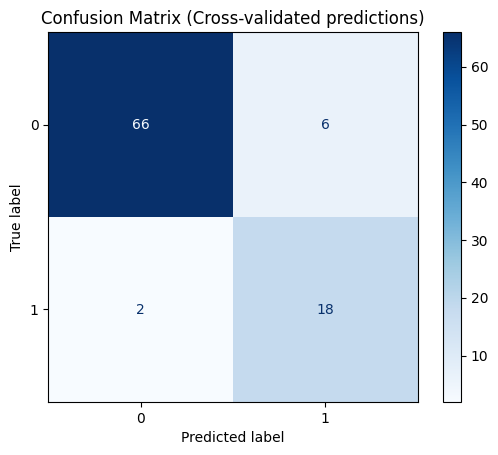

In [211]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_hat_test )

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (Cross-validated predictions)')
plt.show()

In [212]:
from sklearn.metrics import classification_report

cost_metric(y_test, y_hat_test)
print(classification_report(y_test, y_hat_test))

np.int64(130)

              precision    recall  f1-score   support

           0       0.97      0.92      0.94        72
           1       0.75      0.90      0.82        20

    accuracy                           0.91        92
   macro avg       0.86      0.91      0.88        92
weighted avg       0.92      0.91      0.92        92

